  0%|          | 0/300 [00:00<?, ?it/s]

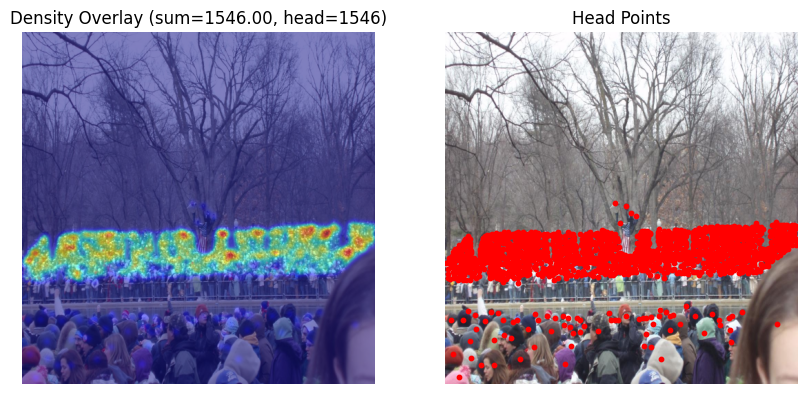

  0%|          | 1/300 [00:00<02:33,  1.94it/s]

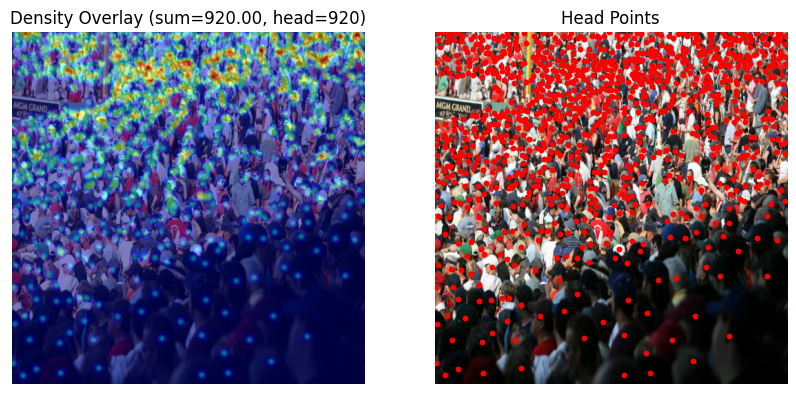

  1%|          | 2/300 [00:01<02:56,  1.68it/s]

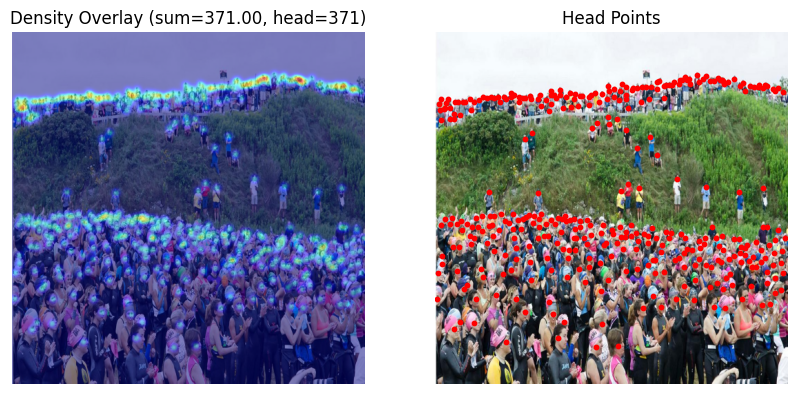

  1%|          | 3/300 [00:01<02:50,  1.74it/s]

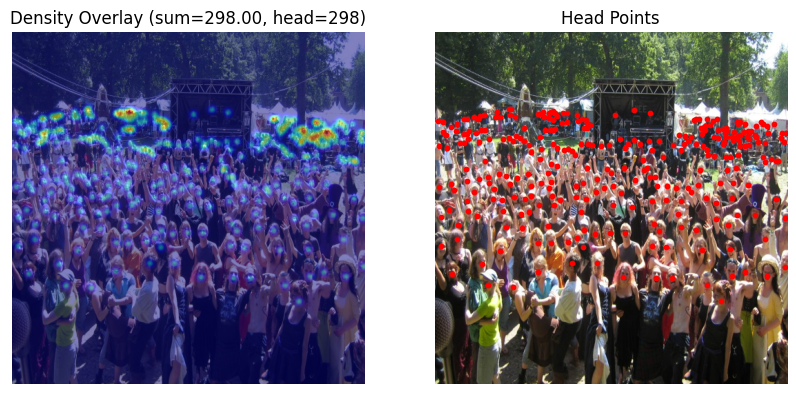

  1%|▏         | 4/300 [00:02<02:51,  1.72it/s]

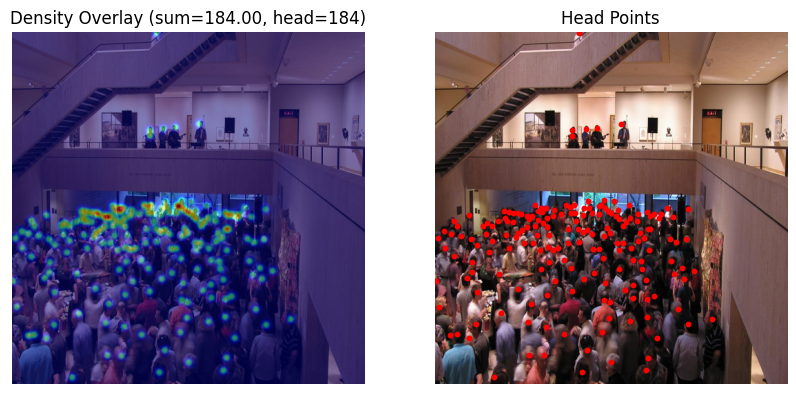

100%|██████████| 300/300 [00:40<00:00,  7.45it/s]

Saved: 300, Bad samples: 0, Large mismatch: 0
All samples look good ✅


In [1]:
import os
import cv2
import numpy as np
import scipy.io as sio
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

# --------------------- Paths ---------------------
images_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\images"
gt_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\ground-truth"
output_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\processed_fixed"
os.makedirs(output_dir, exist_ok=True)

# --------------------- Density Map Generation ---------------------
def generate_density_fixed(points, shape, sigma=4):
    """
    Generate a density map with proper Gaussian for each point
    points: list of (x,y) tuples
    shape: (H, W) of image
    sigma: Gaussian sigma
    """
    H, W = shape
    density = np.zeros((H, W), dtype=np.float32)
    
    for x, y in points:
        if x < 0 or y < 0 or x >= W or y >= H:
            continue
        
        size = int(6*sigma + 1)
        half = size // 2
        x_min, x_max = int(max(0, x-half)), int(min(W, x+half+1))
        y_min, y_max = int(max(0, y-half)), int(min(H, y+half+1))
        
        # Patch coordinates
        x_grid = np.arange(x_min, x_max)
        y_grid = np.arange(y_min, y_max)
        xx, yy = np.meshgrid(x_grid, y_grid)
        
        gaussian = np.exp(-((xx-x)**2 + (yy-y)**2)/(2*sigma**2))
        density[y_min:y_max, x_min:x_max] += gaussian
    
    # Normalize to match total head count
    if density.sum() > 0 and len(points) > 0:
        density = density * (len(points) / density.sum())
    
    return density

# --------------------- Process all images ---------------------
saved, bad, mismatch = 0, [], []

for idx, fname in tqdm(list(enumerate(sorted(os.listdir(images_dir)), 1))):
    if not fname.endswith(".jpg"):
        continue

    img_path = os.path.join(images_dir, fname)
    mat_path = os.path.join(gt_dir, f"GT_{os.path.splitext(fname)[0]}.mat")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Resize image to 512x512
    img_resized = cv2.resize(img, (512,512))
    scale_x, scale_y = 512/w, 512/h

    # Load ground truth points
    mat = sio.loadmat(mat_path)
    ann = mat["image_info"][0][0][0][0][0]
    head_count = len(ann)
    
    if head_count == 0:
        bad.append(fname)
        continue

    # Scale points according to resized image
    scaled_pts = [(p[0]*scale_x, p[1]*scale_y) for p in ann]

    # Generate density map
    den_full = generate_density_fixed(scaled_pts, (512,512), sigma=4)
    den_small = cv2.resize(den_full, (64,64), interpolation=cv2.INTER_CUBIC)
    den_small = den_small.reshape(1,64,64)

    # Transpose image to CxHxW
    img_t = img_resized.transpose(2,0,1)

    if den_small.sum() == 0:
        bad.append(fname)
        continue

    # Save processed data
    np.save(os.path.join(output_dir, f"IMG_{idx}_img.npy"), img_t)
    np.save(os.path.join(output_dir, f"IMG_{idx}_den.npy"), den_small)
    saved += 1

    # --------------------- Sanity Check Visualization ---------------------
    # Compute density sum ratio
    density_sum = den_full.sum()
    ratio = density_sum / head_count
    if ratio < 0.9 or ratio > 1.1:
        mismatch.append(fname)

    if idx <= 5:  # visualize first 5 images for sanity
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(img_resized)
        plt.imshow(cv2.resize(den_full, (512,512)), cmap='jet', alpha=0.5)
        plt.title(f"Density Overlay (sum={density_sum:.2f}, head={head_count})")
        plt.axis('off')

        plt.subplot(1,2,2)
        y_pts = [int(p[1]) for p in scaled_pts]
        x_pts = [int(p[0]) for p in scaled_pts]
        plt.imshow(img_resized)
        plt.scatter(x_pts, y_pts, c='red', s=10)
        plt.title("Head Points")
        plt.axis('off')
        plt.show()

print(f"Saved: {saved}, Bad samples: {len(bad)}, Large mismatch: {len(mismatch)}")
if mismatch:
    print("Check these images for density/head mismatch:", mismatch)
else:
    print("All samples look good ✅")


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import tqdm

# --------------------- Dataset ---------------------
class CrowdDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.img_files = sorted([f for f in os.listdir(data_dir) if f.endswith("_img.npy")])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        den_file = img_file.replace("_img.npy", "_den.npy")
        img = np.load(os.path.join(self.data_dir, img_file)).astype(np.float32) / 255.0
        den = np.load(os.path.join(self.data_dir, den_file)).astype(np.float32)
        return torch.from_numpy(img), torch.from_numpy(den)

# --------------------- Paths ---------------------
data_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\processed_fixed"

dataset = CrowdDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# --------------------- Model ---------------------
from torchvision import models
import torch.nn.functional as F

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        vgg = models.vgg16(pretrained=load_weights)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

# --------------------- Training Setup ---------------------
device = torch.device("cpu")
model = CSRNet().to(device)
criterion = nn.MSELoss(reduction='sum')  # sum loss is standard for crowd counting
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# --------------------- Training Loop ---------------------
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_count_err = 0.0
    
    for imgs, dens in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs = imgs.to(device)
        dens = dens.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, dens)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Total count error for this batch
        pred_count = outputs.sum().item()
        gt_count = dens.sum().item()
        running_count_err += abs(pred_count - gt_count)

    avg_loss = running_loss / len(dataset)
    avg_count_err = running_count_err / len(dataset)
    print(f"\nEpoch {epoch+1}: Avg Loss={avg_loss:.4f}, Avg Count Error={avg_count_err:.2f}")


d:\Python Projects\DeepVision\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python Projects\DeepVision\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/5:   1%|▏         | 4/300 [00:50<1:01:44, 12.51s/it]


KeyboardInterrupt: 

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# ----- Paths (change this if needed) -----
processed_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\processed_fixed"

device = torch.device("cpu")
model = CSRNet().to(device)

# ----- Load trained model -----
checkpoint = torch.load("csrnet_epoch100.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# ----- List files -----
img_files = sorted([f for f in os.listdir(processed_dir) if f.endswith("_img.npy")])

# ----- Test on 5 random samples -----
for fname in img_files[:5]:   # change to test more
    img_path = os.path.join(processed_dir, fname)
    den_path = img_path.replace("_img.npy", "_den.npy")

    img = np.load(img_path).astype(np.float32)
    den_gt = np.load(den_path).astype(np.float32).reshape(64,64)

    # convert image to tensor
    img_t = torch.from_numpy(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_t).squeeze().cpu().numpy()

    gt_count = den_gt.sum()
    pred_count = pred.sum()

    print(f"\nFile: {fname}")
    print(f"GT Count = {gt_count:.2f}")
    print(f"Pred Count = {pred_count:.2f}")

    # ---- visualize ----
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(img.transpose(1,2,0))
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title(f"GT Density Map (Count={gt_count:.1f})")
    plt.imshow(den_gt, cmap="jet")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title(f"Predicted Density (Count={pred_count:.1f})")
    plt.imshow(pred, cmap="jet")
    plt.axis("off")

    plt.show()


NameError: name 'CSRNet' is not defined